# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**



```
# This is formatted as code
```

## Name: 

## UNI: 

## The Dataset


### Description

This data set contains details of ecommerce product shipment tracking and the target variable is a binary variable reflecting the fact whether the product reached on time or not.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterGrid


## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [4]:
pdDf = pd.read_csv('data.csv')
pdDf.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_On_Time
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


**1.2: Are there any missing values in the dataset?**

In [5]:
total = pdDf.isnull().sum().sort_values(ascending=False)
percent_1 = pdDf.isnull().sum()/pdDf.isnull().count()*100
percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data  = missing_data.reset_index()
missing_data

,index,Total,%
0,ID,0,0.0
1,Warehouse_block,0,0.0
2,Mode_of_Shipment,0,0.0
3,Customer_care_calls,0,0.0
4,Customer_rating,0,0.0
5,Cost_of_the_Product,0,0.0
6,Prior_purchases,0,0.0
7,Product_importance,0,0.0
8,Gender,0,0.0
9,Discount_offered,0,0.0


**1.3: Plot side-by-side bars of class distribtuion for each category for the categorical feature and the target categories.**

**Clarification with Example below : Here `flWinner` is the Target Variable and `descMapName` is a categorical feature. You are required to make such side-by-side bar plot for each categorical feature with repect to it's class distribution with the target feature for our dataset.**

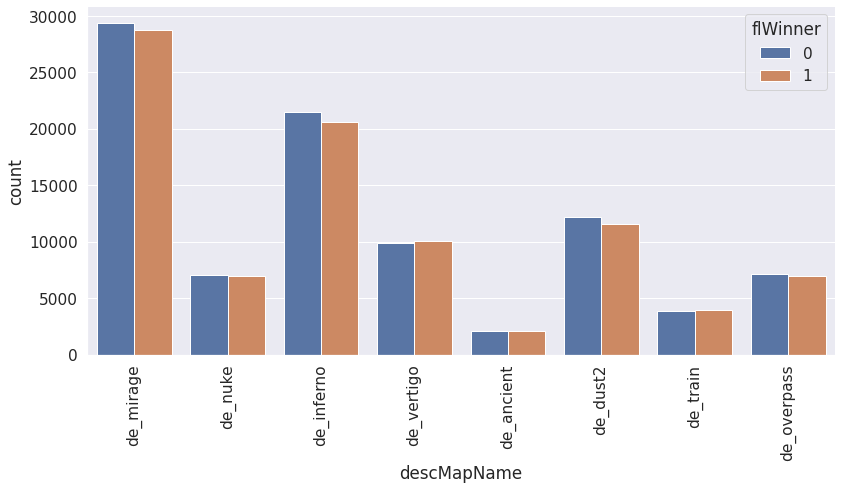

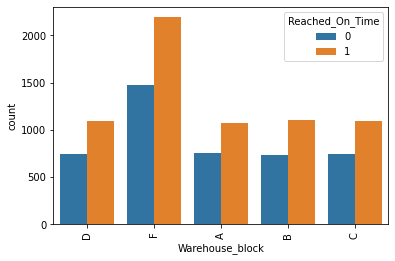

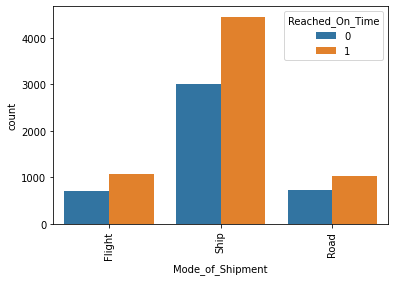

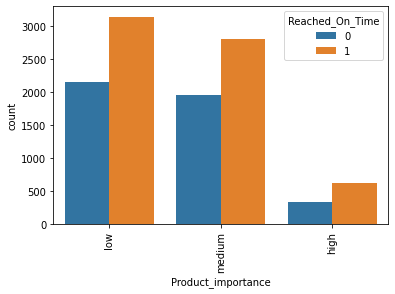

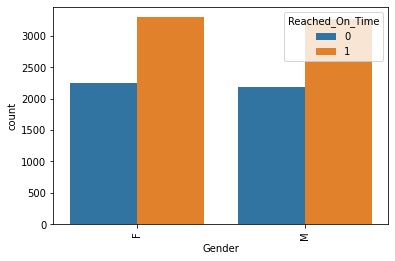

In [6]:
categorical_features = ["Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"]

for i in range(len(categorical_features)):
    sns.countplot(data = pdDf, x = categorical_features[i], hue = "Reached_On_Time")
    plt.xticks(rotation=90)
    plt.show()


**1.4: Explain the distribution of the target variable and the dataset.**


We observe that the data is skewed and the split is 40-60% for class 0 and 1. 


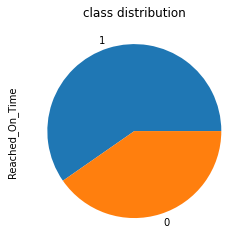

In [7]:
pdDf["Reached_On_Time"].value_counts().plot(kind = "pie")
plt.title("class distribution")
plt.show()

make possitive label the minority

In [8]:
pdDf["Reached_On_Time"] = pdDf["Reached_On_Time"].map(lambda x: x^1)

**1.5: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

**Hint: Based on the distribution of the data, try to use the best splitting strategy.**

Splitting methodologies which can be used are random and stratified splitting strategies as the distribution is partially imbalanced. It is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

In [9]:

X = pdDf.drop(["Reached_On_Time"], axis=1)
y = pdDf["Reached_On_Time"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

#Sort by index and drop new coloumn created by the preprocessing
X_dev = X_dev.sort_index(ascending=True)
X_test = X_test.sort_index(ascending=True)
y_dev = y_dev.sort_index(ascending=True)
y_test = y_test.sort_index(ascending=True)

In [10]:
X_dev

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,1,D,Flight,4,2,177,3,low,F,44,1233
1,2,F,Flight,4,5,216,2,low,M,59,3088
3,4,B,Flight,3,3,176,4,medium,M,10,1177
4,5,C,Flight,2,2,184,3,medium,F,46,2484
5,6,F,Flight,3,1,162,3,medium,F,12,1417
...,...,...,...,...,...,...,...,...,...,...,...
10992,10993,D,Ship,5,1,236,5,medium,M,3,1906
10993,10994,F,Ship,5,1,257,6,low,F,1,1150
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247


**1.6: Would you drop any column? Justify your reasoning.** 

**Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify**



The ID column can be dropped as the feature has least importance is predicting the target variable.

In [11]:
# Dropping 'ID' category
X_dev = X_dev.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

# Get feature names
feature_names = [f"feature {i}" for i in range(X_dev.shape[1])]

# One hot encoding 
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

ohe_features = ['Mode_of_Shipment', 'Warehouse_block', 'Product_importance', 'Gender']
preprocess = make_column_transformer((OneHotEncoder(), ohe_features), remainder='passthrough')
X_dev_before_transform = X_dev.copy()
X_test_before_transform = X_test.copy()
X_dev = preprocess.fit_transform(X_dev)
X_test = preprocess.transform(X_test)

In [12]:
X_test.shape

(2200, 19)

**1.7: Fit a Decision Tree on the development data until all leaves are pure. What is the performance of the tree on the development set and test set? Evaluate test and train accuarcy on F-1 score and accuracy.**

In [13]:
clf = DecisionTreeClassifier(criterion='entropy')

# Train Decision Tree Classifer
clf = clf.fit(X_dev,y_dev)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Train score : {} ".format(clf.score(X_dev, y_dev)))
print("Test score : {} ".format(clf.score(X_test, y_test)))

# Classification report
print()
print("Classification Report")
print(classification_report(y_test, y_pred))

print()
print("F1 score")
print(f1_score(y_test, y_pred))

Accuracy: 0.6359090909090909
Train score : 1.0 
Test score : 0.6359090909090909 

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1313
           1       0.55      0.55      0.55       887

    accuracy                           0.64      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.64      0.64      0.64      2200


F1 score
0.5507571508693213


**1.8: Visualize the trained tree until the max_depth 8.**

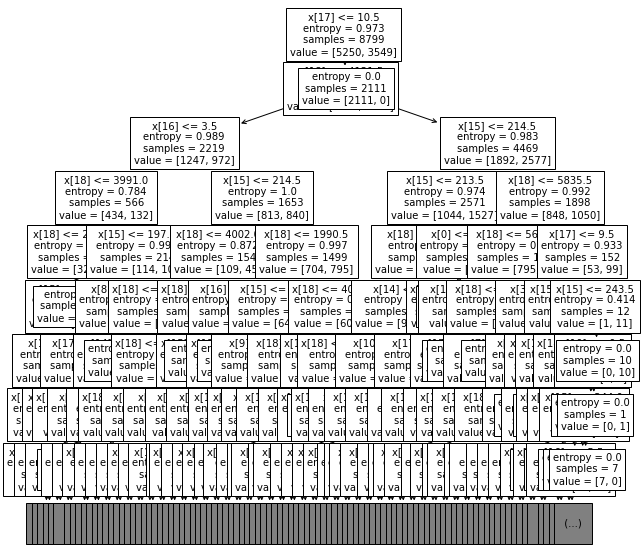

In [14]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(clf, fontsize = 10, max_depth=8)

plt.show()

**1.9: Prune the tree using one of the techniques discussed in class and evaluate the performance.**

**Print the optimal value of the tuned parameter.**

Text(0, 0.5, 'Total impurity of the leaves')

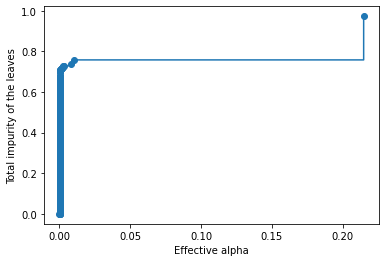

In [15]:
path = clf.cost_complexity_pruning_path(X_dev, y_dev)

fig, ax = plt.subplots()
ax.plot(path.ccp_alphas, path.impurities, marker="o", drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of the leaves")

Text(0, 0.5, 'total depth')

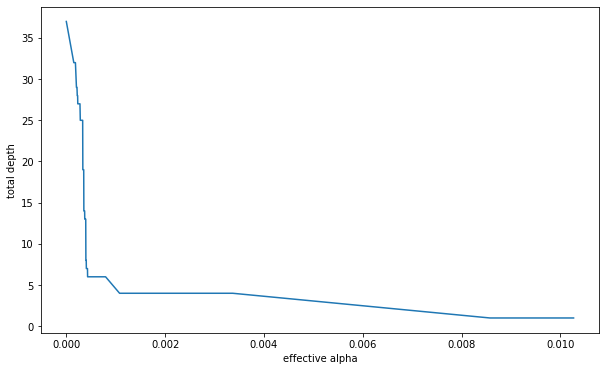

In [16]:
# Finding optimal value of alpha
clfs = []

ccp_alphas, impurities = path.ccp_alphas, path.impurities
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_dev, y_dev)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

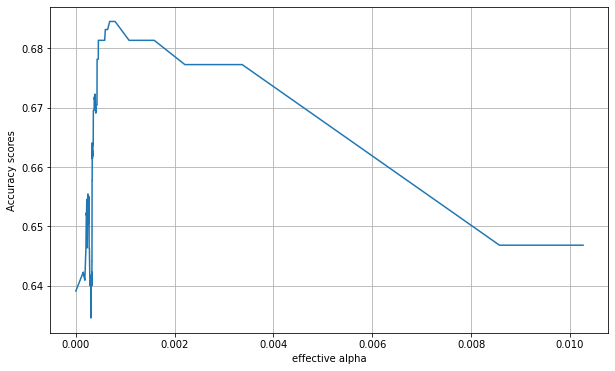

In [17]:
from sklearn.metrics import accuracy_score

acc_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

In [18]:
clf = DecisionTreeClassifier(ccp_alpha=0.007)

clf = clf.fit(X_dev,y_dev)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6468181818181818


In [19]:
index_max = np.argmax(np.array(acc_scores[:-1]))
best_alpha = ccp_alphas[index_max]
print("The best performance on test data is : {} , and the corresponding alpha value is {}".format(acc_scores[index_max], best_alpha))

The best performance on test data is : 0.6845454545454546 , and the corresponding alpha value is 0.0006855898012087178


In [20]:
data_y_test_pred = clf.predict(X_test)

# Accuracy score
print("Train score : {} ".format(clf.score(X_dev, y_dev)))
print("Test score : {} ".format(clf.score(X_test, y_test)))

# Classification report
print()
print("Classification Report")
print(classification_report(y_test, data_y_test_pred))

print()
print("F1 score")
print(f1_score(y_test, data_y_test_pred))

Train score : 0.6432549153312876 
Test score : 0.6468181818181818 

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.41      0.58      1313
           1       0.53      1.00      0.70       887

    accuracy                           0.65      2200
   macro avg       0.77      0.70      0.64      2200
weighted avg       0.81      0.65      0.63      2200


F1 score
0.6954135633085065


**1.10: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

In [21]:
# Select the best accuracy alpha values and train again
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
clf.fit(X_dev, y_dev)

#Computing importance features
importances = clf.feature_importances_

In [22]:
num_features = ['Weight_in_gms', 'Prior_purchases',
                'Discount_offered', 'Customer_rating',
                'Customer_care_calls', 'Cost_of_the_Product']
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names_out()
feature_names = ohe_feature_names.tolist() + num_features

In [23]:
# Sort the importances
zipped_lists = zip(importances, feature_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
importances, feature_names = [ list(tuple) for tuple in  tuples]

importances = importances[::-1]
feature_names = feature_names[::-1]

In [24]:
print(feature_names)

['Customer_care_calls', 'Cost_of_the_Product', 'Customer_rating', 'Discount_offered', 'Weight_in_gms', 'Warehouse_block_F', 'Warehouse_block_D', 'Warehouse_block_C', 'Warehouse_block_B', 'Warehouse_block_A', 'Product_importance_medium', 'Product_importance_low', 'Product_importance_high', 'Prior_purchases', 'Mode_of_Shipment_Ship', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Flight', 'Gender_M', 'Gender_F']


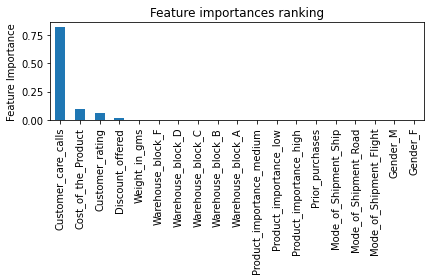

In [25]:
# Plot importance features
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances ranking")
ax.set_ylabel("Feature Importance")
fig.tight_layout()

The three most important features are :- "Customer care calls", "Cost of the product" and "Customer rating". These are computed by summing up the feature importances for each feature of the trained tree. 

## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Use accuracy and F1 score to evaluate. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.7)?**

In [26]:

# Train model using default params
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_dev, y_dev)

y_test_pred = RF_classifier.predict(X_test)

# Accuracy score
print("Train accuray : {} ".format(accuracy_score(RF_classifier.predict(X_dev), y_dev)))
print("Test accuracy : {} ".format(accuracy_score(RF_classifier.predict(X_test), y_test)))


print()
print("Test data F1 score: ", f1_score(y_test, y_test_pred))


Train accuray : 1.0 
Test accuracy : 0.6554545454545454 

Test data F1 score:  0.6171717171717173


Slight increase in accuracy and F1 score

**2.2: Do all trees in the trained random forest model have pure leaves? How would you verify that all trees have pure leaves? Print the score (mean accuracy) values of your choosen method**

In [27]:
def bfs(clf):
    '''Implementing Breadth First Search to find the Impurities in the Leaf Nodes'''
    q = [0]
    l_c = clf.tree_.children_left
    r_c = clf.tree_.children_right
    imp = clf.tree_.impurity
    imp_leaf = []
    while q:
        temp = q.pop(0)
        # If left child and right child are same it means that it is a leaf node.
        if l_c[temp] == r_c[temp]:
            impurity = imp[temp]
            imp_leaf.append(impurity)
        else:
            q.append(l_c[temp])
            q.append(r_c[temp])
    return imp_leaf

trees = RF_classifier.estimators_
for dec_tree in trees:
    leaf_node_impurity = bfs(dec_tree)
    assert all(leaf_node_impurity) == 0.0

All trees in the trained random forest model have pure leaves.

In [28]:
scores=[]
for e in RF_classifier.estimators_ :
  training_score = e.score(X_dev, y_dev)
  scores.append(training_score)
print(scores)

[0.8675985907489487, 0.8660075008523695, 0.8622570746675758, 0.8686214342538925, 0.8678258893056029, 0.8649846573474258, 0.8660075008523695, 0.8564609614728946, 0.8662347994090237, 0.8678258893056029, 0.8670303443573133, 0.8632799181725196, 0.8630526196158654, 0.8725991589953404, 0.86521195590408, 0.8625980225025571, 0.8681668371405842, 0.8613478804409592, 0.8630526196158654, 0.86793953858393, 0.8729401068303216, 0.8648710080690988, 0.8655529037390612, 0.8655529037390612, 0.8729401068303216, 0.8655529037390612, 0.8621434253892488, 0.8711217183770883, 0.866575747244005, 0.8622570746675758, 0.8610069326059779, 0.8697579270371633, 0.8657802022957154, 0.872144561882032, 0.8694169792021821, 0.8678258893056029, 0.869303329923855, 0.8655529037390612, 0.869303329923855, 0.8686214342538925, 0.8660075008523695, 0.8653256051824071, 0.8672576429139675, 0.86521195590408, 0.8666893965223321, 0.8695306284805091, 0.866575747244005, 0.8646437095124446, 0.8614615297192862, 0.8681668371405842, 0.86862143

Even though the score of dev dataset is less than 1, we can not see the tree is impure, for Random Forest just use a subset of dev dataset to train each tree.

**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


Since there seems to be an overfitting issue, n_estimators (controls number of trees)
and min samples split (can help control overfitting by limiting the number of min samples in splits).

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

"n_estimators":[50,80,100,130,150],
"min_samples_split":  [8,10,12,13,15]

**2.5: Perform model selection using the chosen values for the hyperparameters. Use out-of-bag (OOB) error for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on train and test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [ ]:
params = {"n_estimators":[50,80,100,130,150],
              "min_samples_split":  [8,10,12,13,15]}

# clf_rfc_a = GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
#                        param_grid = params, cv=StratifiedKFold(n_splits=5, shuffle=False))
# clf_rfc_a.fit(X_dev,y_dev)

# print("best hyperparameters:", clf_rfc_a.best_params_)
# print("mean cross-validated score with best hyperparameters:", clf_rfc_a.best_score_)

In [ ]:
estimator = RandomForestClassifier(random_state=10, oob_score=True)
best_score = -1
for g in ParameterGrid(params):
    estimator.set_params(**g)
    estimator.fit(X_dev,y_dev)
    # save if best
    if estimator.oob_score_ > best_score:
        best_score = estimator.oob_score_
        best_grid = g

print("OOB: %0.5f"%best_score)
print("Grid:", best_grid)

OOB: 0.66746
Grid: {'min_samples_split': 12, 'n_estimators': 150}


In [ ]:
clf_rfc_best = RandomForestClassifier(min_samples_split = best_grid["min_samples_split"], 
                                         n_estimators = best_grid["n_estimators"],
                                         random_state=10)
clf_rfc_best.fit(X_dev, y_dev)
y_pred = clf_rfc_best.predict(X_test)
print(f1_score(y_test, y_pred))
score_rfc = precision_recall_fscore_support(y_test, y_pred, average = "binary")
print("Accuracy for RandomForestClassifier on testing data with best hyperparameters:")
print("Precision : ", score_rfc[0])
print("Recall : ", score_rfc[1])
print("F1 Score : ", score_rfc[2])

print(classification_report(y_test, y_pred))

# Accuracy score
print("Train accuray : {} ".format(accuracy_score(clf_rfc_best.predict(X_dev), y_dev)))
print("Test accuracy : {} ".format(accuracy_score(clf_rfc_best.predict(X_test), y_test)))

0.6423427748439751
Accuracy for RandomForestClassifier on testing data with best hyperparameters:
Precision :  0.5593645484949833
Recall :  0.7542277339346111
F1 Score :  0.6423427748439751
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      1313
           1       0.56      0.75      0.64       887

    accuracy                           0.66      2200
   macro avg       0.67      0.68      0.66      2200
weighted avg       0.69      0.66      0.66      2200

Train accuray : 0.9524946016592795 
Test accuracy : 0.6613636363636364 


Increase in both accuracy and F1-score compared to Q2.1

 **2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.10? If they differ, which feature set makes more sense?**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


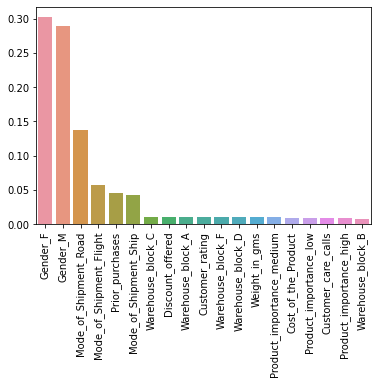

In [ ]:
feat_imps = zip(feature_names, clf_rfc_best.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x:x[1] !=0, feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(list(feats),list(imps))
ax.tick_params(axis="x", rotation=90)

For our tuned random forest classifier Gender_F, Gender_M and Mode_of_shipment_road are the three
most important features. For the single decision tree, it was customer_care_calls, cost_of_the_product and customer_rating.

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. For each hyperparmeter, give it 3 potential values. Report on the time taken to do model selection for the model. Also, report the performance of the test dataset from the optimal models.**

In [ ]:
t = time.time()
param = {'learning_rate':[0.1, 0.01, 0.001], 
               'max_depth':[3, 6, 9],
               'l2_regularization': np.logspace(-3, -1, 3)}
clf_hgb = make_pipeline(preprocess, 
                        GridSearchCV(estimator = HistGradientBoostingClassifier(random_state=10), 
                                     param_grid = param,
                                     cv=StratifiedKFold(n_splits=5, shuffle=False)))
clf_hgb.fit(X_dev_before_transform,y_dev)
print(f'time cost:{time.time()-t:.8f}s')
print("best hyperparameters:", clf_hgb["gridsearchcv"].best_params_)
print("mean cross-validated score with best hyperparameters:", clf_hgb["gridsearchcv"].best_score_)

time cost:61.74085307s
best hyperparameters: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_depth': 6}
mean cross-validated score with best hyperparameters: 0.6027754664323737


In [ ]:
clf_hgb_best = HistGradientBoostingClassifier(learning_rate = clf_hgb["gridsearchcv"].best_params_["learning_rate"], 
                                         max_depth = clf_hgb["gridsearchcv"].best_params_["max_depth"], 
                                         l2_regularization = clf_hgb["gridsearchcv"].best_params_['l2_regularization'],
                                         random_state=10)
clf_hgb_best.fit(X_dev, y_dev)
y_pred = clf_hgb_best.predict(X_test)
score_hgb = accuracy_score(y_test, y_pred)
print("Accuracy for GradientBoostingClassifier on testing data with best hyperparameters:", score_hgb)
print(classification_report(y_test, y_pred))

Accuracy for GradientBoostingClassifier on testing data with best hyperparameters: 0.6636363636363637
              precision    recall  f1-score   support

           0       0.80      0.58      0.67      1313
           1       0.56      0.79      0.65       887

    accuracy                           0.66      2200
   macro avg       0.68      0.68      0.66      2200
weighted avg       0.70      0.66      0.67      2200



**3.2: Repeat 3.1 for XGBoost.**

**Note**: For XGBoost, you **DO NOT NEED** to choose the same hyperparameters as HistGradientBoostingClassifier.

In [ ]:
t = time.time()
param = {'learning_rate':[0.05, 0.01, 0.005], 
               'n_estimators':[20, 30, 40], 
               'max_depth':[3, 6, 9]}
clf_xgb = make_pipeline(preprocess,
                        GridSearchCV(estimator = XGBClassifier(random_state=10), 
                                     param_grid = param,
                                     cv=StratifiedKFold(n_splits=5, shuffle=False)))
clf_xgb.fit(X_dev_before_transform,y_dev)
print(f'cost:{time.time()-t:.8f}s')

cost:44.75418639s


In [ ]:
print("best hyperparameters:", clf_xgb["gridsearchcv"].best_params_)
print("best scores:", clf_xgb["gridsearchcv"].best_score_)

best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 30}
best scores: 0.6105002842524161


In [ ]:
clf_xgb_best = XGBClassifier(learning_rate = clf_xgb["gridsearchcv"].best_params_["learning_rate"], 
                                          max_depth = clf_xgb["gridsearchcv"].best_params_["max_depth"], 
                                          n_estimators = clf_xgb["gridsearchcv"].best_params_["n_estimators"],
                                          random_state=10)
clf_xgb_best.fit(X_dev, y_dev)
y_pred = clf_xgb_best.predict(X_test)
score_xgb = accuracy_score(y_test, y_pred)
print("Accuracy for GradientBoostingClassifier on testing data with best hyperparameters:", score_xgb)
print(classification_report(y_test, y_pred))

Accuracy for GradientBoostingClassifier on testing data with best hyperparameters: 0.6845454545454546
              precision    recall  f1-score   support

           0       0.94      0.51      0.66      1313
           1       0.56      0.95      0.71       887

    accuracy                           0.68      2200
   macro avg       0.75      0.73      0.68      2200
weighted avg       0.79      0.68      0.68      2200



**3.3: Compare the results on the test dataset of XGBoost and HistGradientBoostingClassifier. Which model do you prefer and why?**

In [ ]:
print("HistGradientBoostingClassifier:", score_hgb)
print("XGBoost:", score_xgb)

HistGradientBoostingClassifier: 0.6636363636363637
XGBoost: 0.6845454545454546


I prefer XGBoost for it has the highest performance and the lowest time cost.

**3.4: Can you list the top 3 important features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree?**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


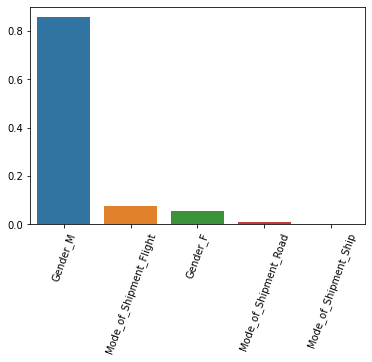

In [ ]:
feat_imps = zip(feature_names, clf_xgb_best.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x:x[1] !=0, feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(list(feats),list(imps))
ax.tick_params(axis="x", rotation=70)

The top 3 features from XGBoost is similar to that from Random Forest but totally different with that from Decision Tree.

**3.5: Can you choose the top 5 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [ ]:
features_top = list(feats)[:5]
X_dev_new = X_dev_new = pd.DataFrame(X_dev, columns = feature_names)
X_dev_new = X_dev_new[features_top]
X_dev_new.head()

,Gender_M,Mode_of_Shipment_Flight,Gender_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
0,44.0,3.0,1233.0,177.0,2.0
1,59.0,2.0,3088.0,216.0,5.0
2,10.0,4.0,1177.0,176.0,3.0
3,46.0,3.0,2484.0,184.0,2.0
4,12.0,3.0,1417.0,162.0,1.0


In [ ]:
X_dev_new = X_dev_new.to_numpy()

In [ ]:
t = time.time()
param = {'learning_rate':[0.05, 0.01, 0.005], 
               'n_estimators':[20, 30, 40], 
               'max_depth':[3, 6, 9]}
clf_xgb_new = make_pipeline(GridSearchCV(estimator = XGBClassifier(random_state=10), 
                           param_grid = param,
                           cv=StratifiedKFold(n_splits=5, shuffle=False)))
clf_xgb_new.fit(X_dev_new,y_dev)
print(f'cost:{time.time()-t:.8f}s')

cost:23.20161510s


In [ ]:
print("best hyperparameters:", clf_xgb_new["gridsearchcv"].best_params_)
print("best scores:", clf_xgb_new["gridsearchcv"].best_score_)

best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 30}
best scores: 0.6140230115251434


In [ ]:
clf_xgb_new_best = XGBClassifier(learning_rate = clf_xgb_new["gridsearchcv"].best_params_["learning_rate"], 
                                         max_depth = clf_xgb_new["gridsearchcv"].best_params_["max_depth"], 
                                         n_estimators = clf_xgb_new["gridsearchcv"].best_params_["n_estimators"],
                                         random_state=10)
clf_xgb_new_best.fit(X_dev, y_dev)
y_pred = clf_xgb_new_best.predict(X_test)
score_xgb_new = accuracy_score(y_test, y_pred)
print("Accuracy for XGBoost on testing data with best hyperparameters:", score_xgb_new)

Accuracy for XGBoost on testing data with best hyperparameters: 0.6845454545454546


The performance of these two models are similar, cause the features other than the top five don't play a big role in this model

## Question 4: Calibration

**4.1: Estimate the brier score for the HistGradientBoosting model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [ ]:
X_train, X_calib, y_train, y_calib = train_test_split(X_dev_before_transform, y_dev, test_size = 0.20, random_state = 0)

In [ ]:
clf_hgb_baseline = make_pipeline(preprocess,
                                 HistGradientBoostingClassifier(learning_rate = clf_hgb["gridsearchcv"].best_params_["learning_rate"], 
                                         max_depth = clf_hgb["gridsearchcv"].best_params_["max_depth"], 
                                         l2_regularization = clf_hgb["gridsearchcv"].best_params_['l2_regularization'],
                                         random_state=10))
clf_hgb_baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Mode_of_Shipment',
                                                   'Warehouse_block',
                                                   'Product_importance',
                                                   'Gender'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=0.001,
                                                max_depth=6,
                                                random_state=10))])

In [ ]:
probs = clf_hgb_baseline.predict_proba(X_test_before_transform)[:, 1]
loss_hgb = brier_score_loss(y_test, probs)
print("brier score for the XGBoost Model:", loss_hgb)

brier score for the XGBoost Model: 0.18470610991356243


**4.2: Calibrate the trained HistGradientBoosting model using Platt Scaling. Print the brier score after calibration and plot predicted v.s. actual on test datasets from the calibration method.**

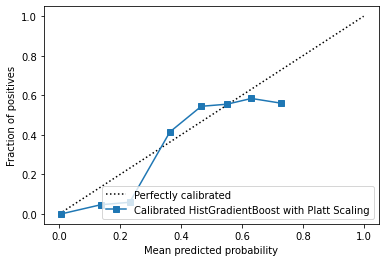

In [ ]:
clf_hgb_platt = CalibratedClassifierCV(clf_hgb_baseline, cv="prefit", method="sigmoid")
clf_hgb_platt.fit(X_calib, y_calib)
display = CalibrationDisplay.from_estimator(
    clf_hgb_platt, X_test_before_transform, y_test, n_bins=10, name = "Calibrated HistGradientBoost with Platt Scaling"
)

In [ ]:
probs = clf_hgb_platt.predict_proba(X_test_before_transform)[:,1]
loss_hgb_platt = brier_score_loss(y_test, probs)
print("brier score for the XGBoost Model with platt scaling:", loss_hgb_platt)

brier score for the XGBoost Model with platt scaling: 0.18131611854078192


**4.3: Compare the brier scores from 4.1 and 4.2. Do the calibration methods help in having better predicted probabilities?**

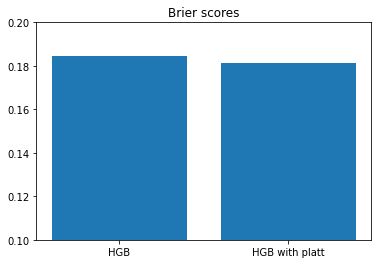

In [ ]:
plt.bar(x = ["HGB", "HGB with platt"], height = [loss_hgb, loss_hgb_platt])
plt.ylim(0.1, 0.20)
plt.title("Brier scores")
plt.show()

Calibration method do slightly help in having better predicted probabilities in this question.